In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import argparse
import os
import tqdm
import scipy.ndimage as nd
from torchvision import transforms

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 15, 10




## What exactly is a deep dream ? 

What we're doing in a deep dream is basically maximizing the activations of a particular label within the layer(s) of the model by altering the input image. 

Sometimes this helps us visualize the patterns learned by a neural network. 

For example, if we train a model to classify between a tree and a dog. Some of it's neurons would "activate" when it sees leaves, branches, etc. While some of it's other neurons would fire up when it sees tails and ears and noses. 

Now in a deep dream, if the same model is fed an image, and some parts of the image looks like a tree to the model, we alter the image such that those parts look more like a tree.  




**TL;DR:** If the model/layer thinks that it's a cat, make it look more like a cat

Stuff to read:
* [The tensorflow tutorial](https://www.tensorflow.org/tutorials/generative/deepdream) (Even though I didn't do it on TF, it's the same idea)
* [Some presentation I found by Anita Wasilewska](https://www3.cs.stonybrook.edu/~cse352/T12talk.pdf)

## Loading up the input image and the model

In our case, we're using the pre-trained VGG19. This one is a bit conveninent for now because of the fact that It can handle input images of different sizes. Thanks to it's [AdaptiveAvgPool2d](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html) layer. 

In [73]:
import os
!wget https://i.pinimg.com/originals/2e/8c/84/2e8c84564c24422e32f755b79b7d5907.jpg

--2020-08-28 11:49:59--  https://i.pinimg.com/originals/2e/8c/84/2e8c84564c24422e32f755b79b7d5907.jpg
Resolving i.pinimg.com (i.pinimg.com)... 104.93.0.250, 2600:1417:76:480::1931, 2600:1417:76:499::1931, ...
Connecting to i.pinimg.com (i.pinimg.com)|104.93.0.250|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72445 (71K) [image/jpeg]
Saving to: ‘2e8c84564c24422e32f755b79b7d5907.jpg’

2e8c84564c24422e32f 100%[===================>]  70.75K  --.-KB/s    in 0.006s  

2020-08-28 11:50:00 (10.9 MB/s) - ‘2e8c84564c24422e32f755b79b7d5907.jpg’ saved [72445/72445]



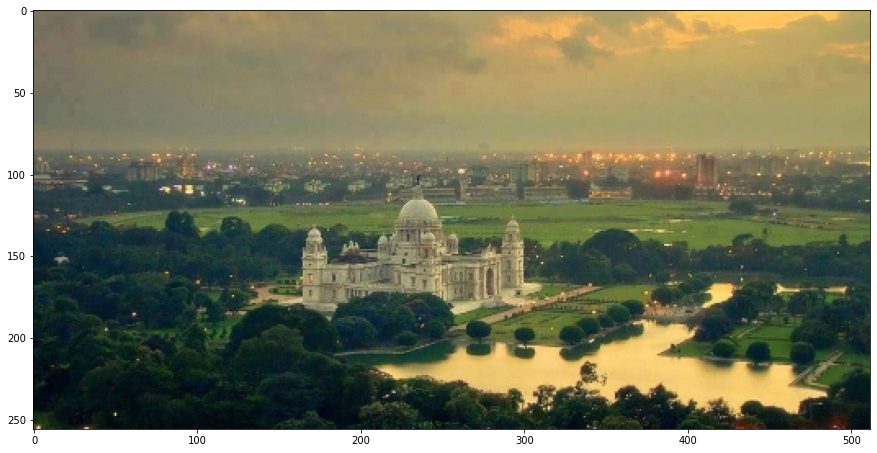

In [105]:
import cv2 

image = cv2.imread("2e8c84564c24422e32f755b79b7d5907.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (512,256))

plt.imshow(image)
plt.show()

In [106]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
preprocess = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

In [107]:
model = models.vgg19(pretrained=True)
layers = list(model.features.children())

if torch.cuda.is_available:
    model = model.cuda()
# print(model)

[Explains norms](https://www.youtube.com/watch?v=tXCqr2UsbWQ)


## The core function


In [87]:



def dream(image, model, iterations, lr):
    """ Updates the image to maximize outputs for n iterations """
    Tensor = torch.cuda.FloatTensor if torch.cuda.is_available else torch.FloatTensor

    image = Variable(Tensor(image), requires_grad=True) ## nice tensor image 

    for i in range(iterations):
        model.zero_grad()
        out = model(image)   ## out = pred 
        loss = out.norm()    ## finds out a nice squared sum form from the weirdly sized pred  i.e euclidean norm 
        loss.backward()                 
        avg_grad = np.abs(image.grad.data.cpu().numpy()).mean()

        norm_lr = lr / avg_grad  ## normalised lr wrt gradient, larger the grad, smaller the lr 

        image.data += norm_lr * image.grad.data  ## un-optimizing the image  wrt the activations to maximize the activations, more iters = crazier stuff I guess
        image.data = clip(image.data)
        image.grad.data.zero_()   ## zeroing the grads of the image 
    return image.cpu().data.numpy()


def clip(image_tensor):
    for c in range(3):
        m, s = mean[c], std[c]
        image_tensor[0, c] = torch.clamp(image_tensor[0, c], -m / s, (1 - m) / s)
    return image_tensor


def deprocess(image_np):
    image_np = image_np.squeeze().transpose(1, 2, 0)
    image_np = image_np * std.reshape((1, 1, 3)) + mean.reshape((1, 1, 3))
    image_np = np.clip(image_np, 0.0, 255.0)
    return image_np


In [88]:
def show_octaves(octaves):

    for octave in octaves:
        sample = np.moveaxis(octave[0],0,2)
        plt.imshow(sample)
        plt.show()

I guess octaves refer to the images which are basically the same thing but different sizes 

In [99]:



"""
feed the model bigger images gradually and then return the so called "sum"
"""

def deep_dream(image, model, iterations, lr, octave_scale, num_octaves):
    """ Main deep dream method """
    image = preprocess(image).unsqueeze(0).cpu().data.numpy()

    # Extract image representations for each octave
    octaves = [image]


    for _ in range(num_octaves - 1):
        octaves.append(nd.zoom(octaves[-1], (1, 1, 1 / octave_scale, 1 / octave_scale), order=1))



    # show_octaves(octaves)
    

    detail = np.zeros_like(octaves[-1])

    """
    Iterate through the list of octaves in reverse order, smaller image to larger image ,
    octave_base referes to the image 

    """

    for octave, octave_base in enumerate(tqdm.tqdm(octaves[::-1], desc="Dreaming")):


        """
        from the 2nd image, i.e the 2nd smallest image, start upsampling the detail from the last iter 
        """
        if octave > 0:
            # Upsample detail to new octave dimension
            detail = nd.zoom(detail, np.array(octave_base.shape) / np.array(detail.shape), order=1)


        # Add deep dream detail from previous octave to new base
        input_image = octave_base + detail
        # Get new deep dream image
        dreamed_image = dream(input_image, model, iterations, lr)
        # Extract deep dream details > details are basically the delta between the dreamed image and the octave base 
        detail = dreamed_image - octave_base

    return deprocess(dreamed_image), detail



Dreaming:   0%|          | 0/7 [00:00<?, ?it/s]

Dreaming:  14%|█▍        | 1/7 [00:01<00:08,  1.40s/it]

Dreaming:  29%|██▊       | 2/7 [00:02<00:07,  1.41s/it]

Dreaming:  43%|████▎     | 3/7 [00:04<00:05,  1.48s/it]

Dreaming:  57%|█████▋    | 4/7 [00:06<00:04,  1.64s/it]

Dreaming:  71%|███████▏  | 5/7 [00:08<00:03,  1.88s/it]

Dreaming:  86%|████████▌ | 6/7 [00:12<00:02,  2.26s/it]

Dreaming: 100%|██████████| 7/7 [00:16<00:00,  2.33s/it]


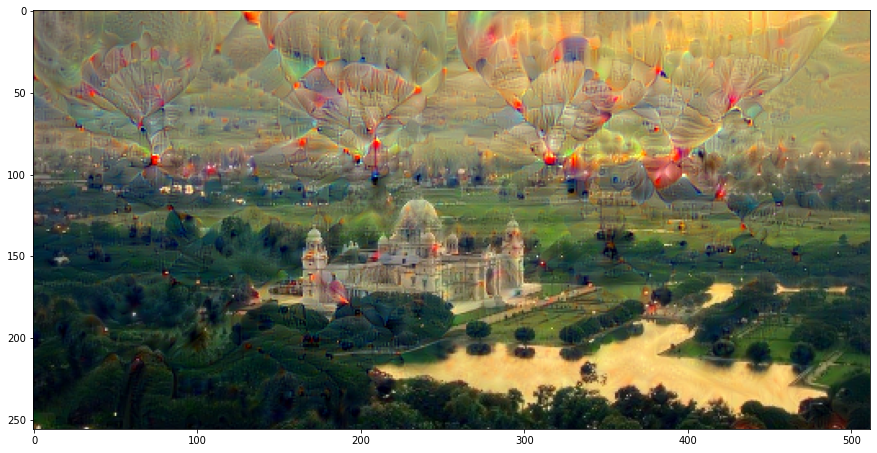

In [111]:
dreamed_image, detail = deep_dream(
        image,
        model,
        iterations=20,
        lr=0.012,
        octave_scale= 1.2,
        num_octaves= 7,
    )

img_1 = (dreamed_image*255).astype(np.uint8)
plt.imshow(img_1)



Dreaming:   0%|          | 0/7 [00:00<?, ?it/s]

Dreaming:  14%|█▍        | 1/7 [00:01<00:08,  1.40s/it]

Dreaming:  29%|██▊       | 2/7 [00:02<00:07,  1.41s/it]

Dreaming:  43%|████▎     | 3/7 [00:04<00:05,  1.48s/it]

Dreaming:  57%|█████▋    | 4/7 [00:06<00:04,  1.64s/it]

Dreaming:  71%|███████▏  | 5/7 [00:09<00:03,  1.92s/it]

Dreaming:  86%|████████▌ | 6/7 [00:12<00:02,  2.30s/it]

Dreaming: 100%|██████████| 7/7 [00:16<00:00,  2.36s/it]


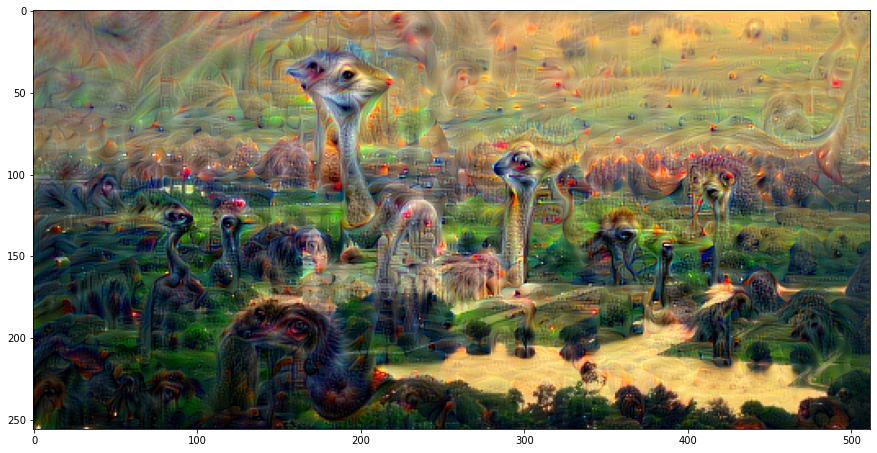

In [112]:
dreamed_image, detail = deep_dream(
        image,
        model,
        iterations=20,
        lr=0.022,
        octave_scale= 1.2,
        num_octaves= 7,
    )

img_2 = (dreamed_image*255).astype(np.uint8)
plt.imshow(img_2)

Text(0.5, 0, 'deep dream with lr = 0.22')

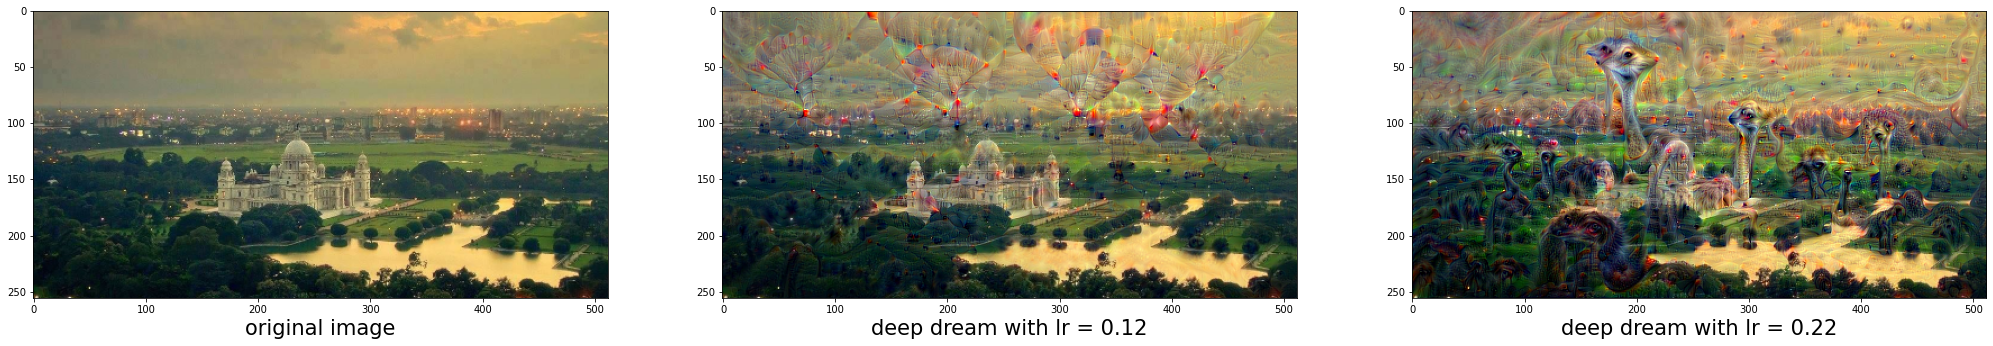

In [122]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (35,15))

ax1.imshow(image)
ax1.set_xlabel("original image", fontsize = 21)

ax2.imshow(img_1)
ax2.set_xlabel("deep dream with lr = 0.12", fontsize = 21)

ax3.imshow(img_2)
ax3.set_xlabel("deep dream with lr = 0.22", fontsize = 21)
